In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Importing the necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import requests
from PIL import Image
from collections import Counter
from tqdm import tqdm

import string
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud ,STOPWORDS
import spacy
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout
from keras.layers import Embedding, BatchNormalization
from keras.utils import to_categorical
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Aggression Dataset

In [ ]:
aggresion_df = pd.read_csv('/content/drive/MyDrive/cyberbullying/aggression_parsed_dataset.csv')
aggresion_df

,index,Text,ed_label_0,ed_label_1,oh_label
0,0,`- This is not ``creative``. Those are the di...,0.900000,0.100000,0
1,1,` :: the term ``standard model`` is itself le...,1.000000,0.000000,0
2,2,"True or false, the situation as of March 200...",1.000000,0.000000,0
3,3,"Next, maybe you could work on being less cond...",0.555556,0.444444,0
4,4,This page will need disambiguation.,1.000000,0.000000,0
...,...,...,...,...,...
115859,115859,` These sources don't exactly exude a sense ...,0.777778,0.222222,0
115860,115860,The Institute for Historical Review is a pee...,1.000000,0.000000,0
115861,115861,:The way you're trying to describe it in this...,1.000000,0.000000,0
115862,115862,== Warning == There is clearly a protection...,0.500000,0.500000,0


In [ ]:
aggresion_df.drop(columns=['index','ed_label_0','ed_label_1'],inplace=True)
aggresion_df.rename(columns={'oh_label': 'Sentiment'}, inplace=True)
aggresion_df.drop_duplicates(inplace=True)
aggresion_df

,Text,Sentiment
0,`- This is not ``creative``. Those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"True or false, the situation as of March 200...",0
3,"Next, maybe you could work on being less cond...",0
4,This page will need disambiguation.,0
...,...,...
115859,` These sources don't exactly exude a sense ...,0
115860,The Institute for Historical Review is a pee...,0
115861,:The way you're trying to describe it in this...,0
115862,== Warning == There is clearly a protection...,0


In [ ]:
aggresion_df.isnull().sum()

Text         0
Sentiment    0
dtype: int64

In [ ]:
def preprocessed_text(text):
    # Remove punctuation
    exclude = string.punctuation
    text = text.translate(str.maketrans('', '', exclude))
    # Remove numericals
    text = re.sub(r'\d+', '', text)
    # Remove mentions and hashtags
    text = re.sub(r'(@[A-Za-z0-9_]+|#\w+)', '', text)
    # Convert into lowercase
    text = text.lower()
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join tokens back into text
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

In [ ]:
aggresion_df['Text'] = aggresion_df['Text'].apply(preprocessed_text)
aggresion_df

,Text,Sentiment
0,creative dictionary definition term insurance ...,0
1,term standard model le npov think wed prefer n...,0
2,true false situation march saudi proposal land...,0
3,next maybe could work le condescending suggest...,0
4,page need disambiguation,0
...,...,...
115859,source dont exactly exude sense impartiality n...,0
115860,institute historical review peerreviewed journ...,0
115861,way youre trying describe article serious step...,0
115862,warning clearly protectionist regime going wit...,0


0    100901
1     14768
Name: Sentiment, dtype: int64


<Axes: xlabel='Sentiment', ylabel='count'>

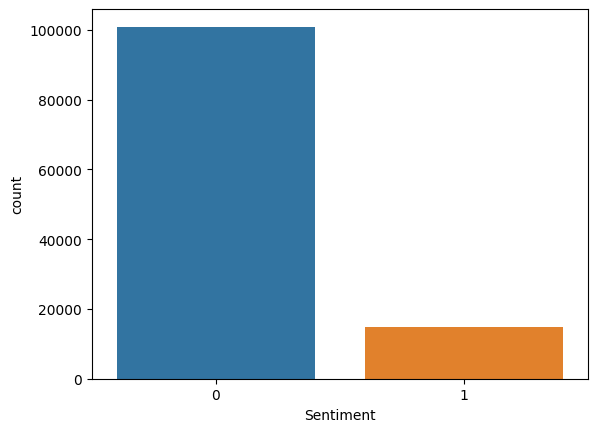

In [ ]:
x = aggresion_df['Sentiment'].value_counts()
print(x)
sns.countplot(aggresion_df, x='Sentiment', palette='tab10')

# WordCloud

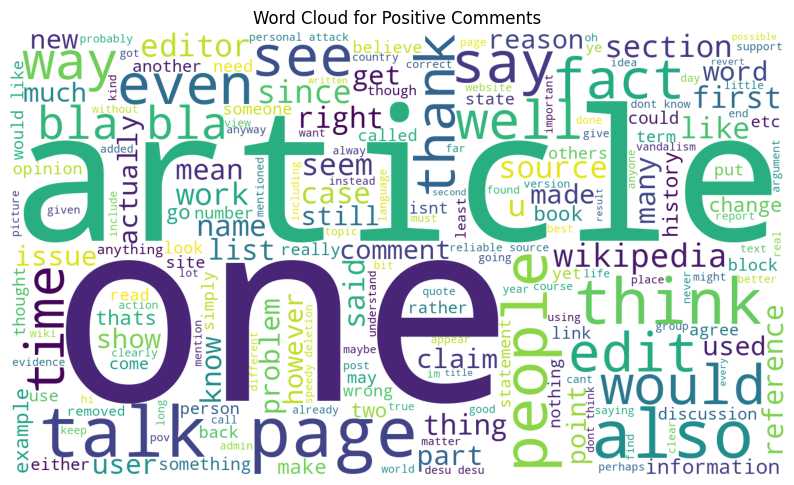

CPU times: user 27.1 s, sys: 1.41 s, total: 28.5 s
Wall time: 44.1 s


In [ ]:
%%time
stop_words = stopwords.words('english')
positive_comments = aggresion_df[aggresion_df['Sentiment'] == 0]['Text']
pos = ' '.join(map(str, positive_comments))
pos_wordcloud = WordCloud(width=1400, height=800,
                          background_color='white',
                         stopwords=stop_words,
                          min_font_size=15).generate(pos)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Positive Comments')
plt.axis('off')
plt.show()

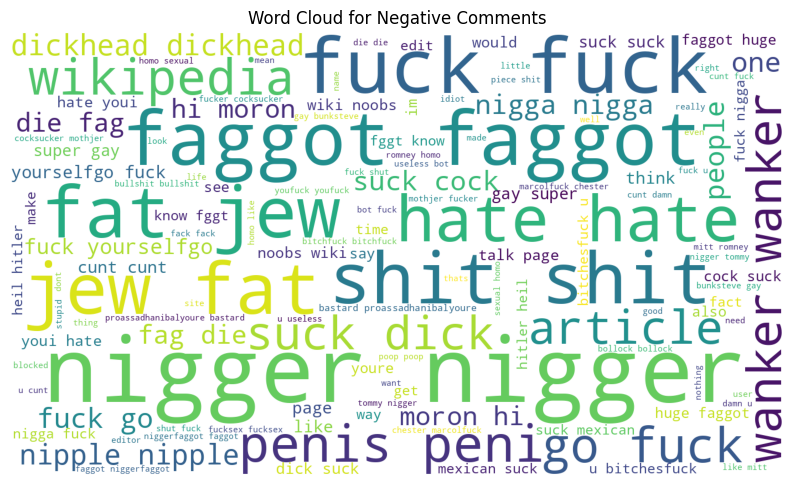

CPU times: user 5.29 s, sys: 274 ms, total: 5.57 s
Wall time: 5.53 s


In [ ]:
%%time
stop_words = stopwords.words('english')
positive_comments = aggresion_df[aggresion_df['Sentiment'] == 1]['Text']
pos = ' '.join(map(str, positive_comments))
pos_wordcloud = WordCloud(width=1400, height=800,
                          background_color='white',
                         stopwords=stop_words,
                          min_font_size=15).generate(pos)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Negative Comments')
plt.axis('off')
plt.show()

In [ ]:
len_text = [len(tx) for tx in aggresion_df['Text'].to_list()]
print(f'Max Length : {np.max(len_text)}')
print(f'Min Length : {np.min(len_text)}')
print(f'Mean Length : {round(np.mean(len_text),2)}')
print(f'Std Length : {round(np.std(len_text),2)}')
print(f'Mew + 2sigma : {round(np.mean(len_text)+ 2 *np.std(len_text),2)}')

Max Length : 10000
Min Length : 0
Mean Length : 256.45
Std Length : 498.02
Mew + 2sigma : 1252.49


# Training model

In [ ]:
# using the cleaned version of the dataset
ros = RandomOverSampler(random_state=42)
X = aggresion_df['Text'].values.reshape(-1, 1)
y = aggresion_df['Sentiment'].values
X_resampled, y_resampled = ros.fit_resample(X, y)
X_resampled = X_resampled[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Create a Tokenizer object
token = Tokenizer()
max_len = 100

# Fit the Tokenizer on the training and testing data
token.fit_on_texts(list(X_train) + list(X_test))

# Generate sequences from the training and testing data
xtrain_seq = token.texts_to_sequences(X_train)
xvalid_seq = token.texts_to_sequences(X_test)

# Pad the sequences to the maximum length
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

# Get the word index
word_index = token.word_index

In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/content/drive/MyDrive/glove.6B.100d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:12, 33065.35it/s]

Found 400000 word vectors.


In [ ]:
# Glove word embeddings

from numpy import asarray, zeros
embedding_dict = dict()
glove_file = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding='utf8')
for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dim = asarray(records[1:], dtype='float32')
  embedding_dict[word] = vector_dim
glove_file.close()

In [ ]:
vocab_length = len(token.word_index) + 1
vocab_length

172558

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 172557/172557 [00:00<00:00, 545021.18it/s]


In [ ]:
embedding_matrix.shape

(172558, 100)

In [ ]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_resampled)))

Original dataset shape Counter({0: 100901, 1: 14768})
Resampled dataset shape Counter({0: 100901, 1: 100901})


# Training

In [ ]:
%%time
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

    # A simple LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     100,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(units=128, dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          17255800  
                                                                 
 lstm_4 (LSTM)               (None, 128)               117248    
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17373177 (66.27 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 17255800 (65.83 MB)
_________________________________________________________________
CPU times: user 545 ms, sys: 94.5 ms, total: 640 ms
Wall time: 1.17 s


In [ ]:
history = model.fit(xtrain_pad, y_train, epochs=10, batch_size=256*strategy.num_replicas_in_sync, validation_split=0.2)

Epoch 1/10
505/505 [==============================] - 11s 16ms/step - loss: 0.3592 - accuracy: 0.8401 - val_loss: 0.3064 - val_accuracy: 0.8683
Epoch 2/10
505/505 [==============================] - 8s 15ms/step - loss: 0.2976 - accuracy: 0.8696 - val_loss: 0.2782 - val_accuracy: 0.8816
Epoch 3/10
505/505 [==============================] - 7s 14ms/step - loss: 0.2704 - accuracy: 0.8824 - val_loss: 0.2608 - val_accuracy: 0.8889
Epoch 4/10
505/505 [==============================] - 8s 15ms/step - loss: 0.2473 - accuracy: 0.8937 - val_loss: 0.2395 - val_accuracy: 0.9002
Epoch 5/10
505/505 [==============================] - 7s 14ms/step - loss: 0.2267 - accuracy: 0.9039 - val_loss: 0.2273 - val_accuracy: 0.9061
Epoch 6/10
505/505 [==============================] - 8s 15ms/step - loss: 0.2083 - accuracy: 0.9136 - val_loss: 0.2038 - val_accuracy: 0.9203
Epoch 7/10
505/505 [==============================] - 7s 14ms/step - loss: 0.1889 - accuracy: 0.9232 - val_loss: 0.1911 - val_accuracy: 0.922

In [ ]:
def plot_graphs(history, metric, loss):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot training and validation accuracy
    axs[0].plot(history.history[metric])
    axs[0].plot(history.history['val_' + metric], '')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel(metric)
    axs[0].legend(['train_' + metric, 'val_' + metric])

    # Plot training and validation loss
    axs[1].plot(history.history[loss])
    axs[1].plot(history.history['val_' + loss], '')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel(loss)
    axs[1].legend(['train_' + loss, 'val_' + loss])

    plt.show()

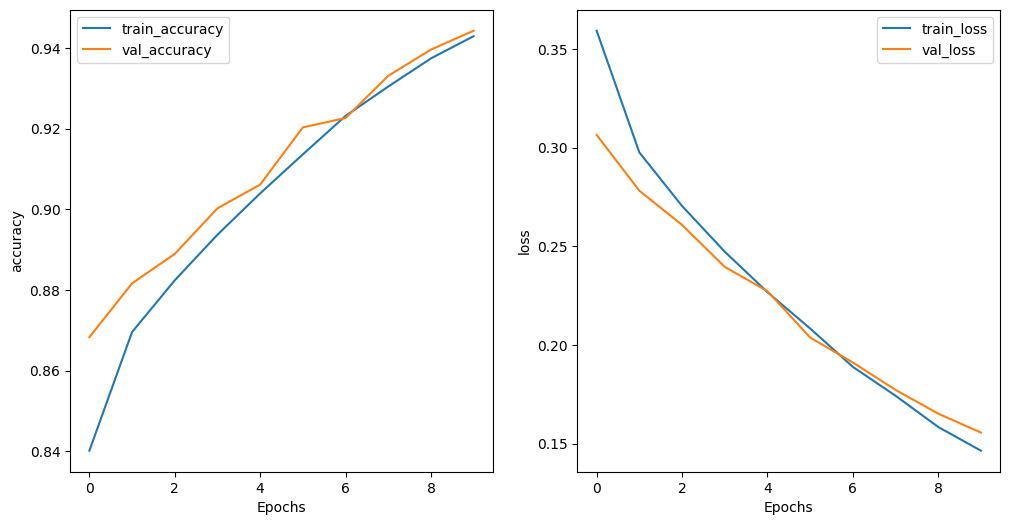

In [ ]:
plot_graphs(history=history,metric='accuracy', loss='loss')

In [ ]:
scores = model.predict(xvalid_pad)
auc = metrics.roc_auc_score(y_test, scores)
print("Auc: %.2f%%" % (auc * 100))

1262/1262 [==============================] - 7s 5ms/step
Auc: 98.40%


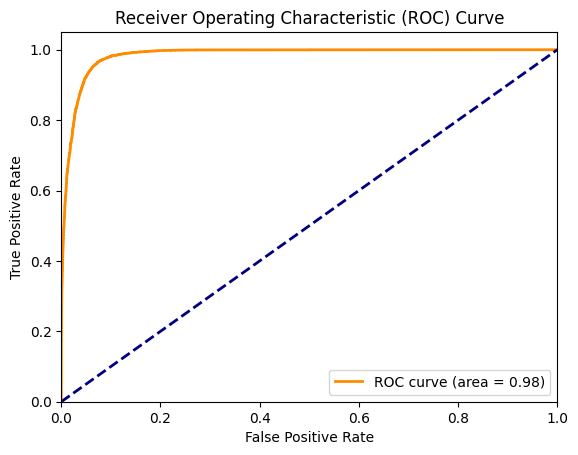

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#import pickle

#with open('lstm_model.pkl', 'wb') as file:
#    pickle.dump(lstm_model, file)

# Kaggle Dataset

In [ ]:
kaggle_df = pd.read_csv('/content/drive/MyDrive/cyberbullying/kaggle_parsed_dataset.csv')
kaggle_df

,index,oh_label,Date,Text
0,0,1,20120618192155Z,"""You fuck your dad."""
1,1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,3,0,NaN,"""listen if you dont wanna get married to a man..."
4,4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."
...,...,...,...,...
8794,8794,0,20120612003508Z,"""Never really gave it much thought. I just fig..."
8795,8795,0,20120619210456Z,"""Nadie se salva de la regla 34 xd"""
8796,8796,0,20120528234613Z,"""Question: Are you a boy or a girl?"""
8797,8797,1,20120619153537Z,"""Leave your email or phone number and maybe yo..."


In [ ]:
kaggle_df.drop(columns=['index','Date'],inplace=True)
kaggle_df.drop_duplicates(inplace=True)
kaggle_df

,oh_label,Text
0,1,"""You fuck your dad."""
1,0,"""i really don't understand your point.\xa0 It ..."
2,0,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,"""listen if you dont wanna get married to a man..."
4,0,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."
...,...,...
8794,0,"""Never really gave it much thought. I just fig..."
8795,0,"""Nadie se salva de la regla 34 xd"""
8796,0,"""Question: Are you a boy or a girl?"""
8797,1,"""Leave your email or phone number and maybe yo..."


In [ ]:
kaggle_df.isnull().sum()

oh_label    0
Text        0
dtype: int64

In [ ]:
kaggle_df['Text'] = kaggle_df['Text'].apply(preprocessed_text)
kaggle_df

,oh_label,Text
0,1,fuck dad
1,0,really dont understand pointxa seems mixing ap...
2,0,axcxamajority canadian wrong againnnunless you...
3,0,listen dont wan na get married man woman dont ...
4,0,cxec buean xuuedng uubueddng biuecu txecnh cxf...
...,...,...
8794,0,never really gave much thought figured back door
8795,0,nadie se salva de la regla xd
8796,0,question boy girl
8797,1,leave email phone number maybe twit meet beat ...


In [ ]:
kaggle_df['oh_label'].value_counts()

0    5970
1    2778
Name: oh_label, dtype: int64

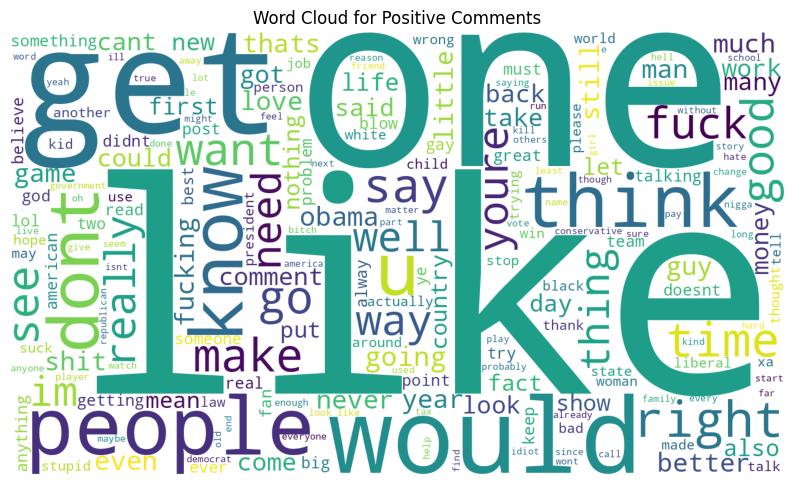

CPU times: user 3.27 s, sys: 167 ms, total: 3.44 s
Wall time: 4.24 s


In [ ]:
%%time
stop_words = stopwords.words('english')
positive_comments = kaggle_df[kaggle_df['oh_label'] == 0]['Text']
pos = ' '.join(map(str, positive_comments))
pos_wordcloud = WordCloud(width=1400, height=800,
                          background_color='white',
                         stopwords=stop_words,
                          min_font_size=15).generate(pos)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Positive Comments')
plt.axis('off')
plt.show()

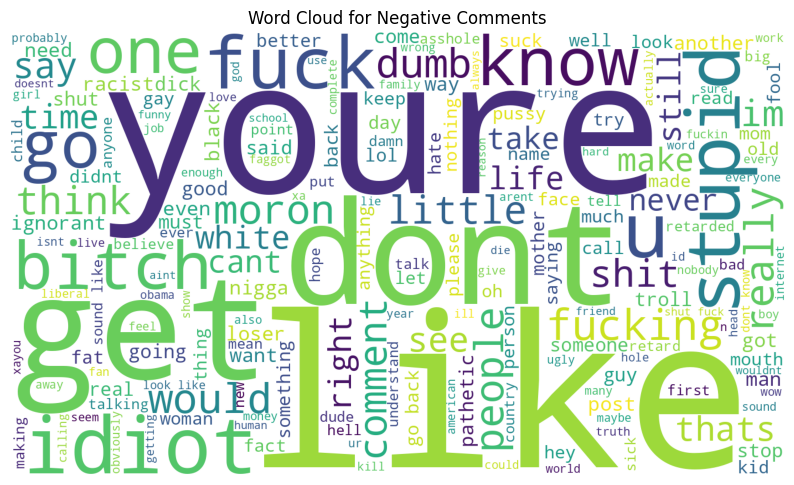

CPU times: user 3.33 s, sys: 168 ms, total: 3.5 s
Wall time: 4.59 s


In [ ]:
%%time
stop_words = stopwords.words('english')
positive_comments = kaggle_df[kaggle_df['oh_label'] == 1]['Text']
pos = ' '.join(map(str, positive_comments))
pos_wordcloud = WordCloud(width=1400, height=800,
                          background_color='white',
                         stopwords=stop_words,
                          min_font_size=15).generate(pos)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Negative Comments')
plt.axis('off')
plt.show()

In [ ]:
len_text = [len(tx) for tx in kaggle_df['Text'].to_list()]
print(f'Max Length : {np.max(len_text)}')
print(f'Min Length : {np.min(len_text)}')
print(f'Mean Length : {round(np.mean(len_text),2)}')
print(f'Std Length : {round(np.std(len_text),2)}')
print(f'Mew + 2sigma : {round(np.mean(len_text)+ 2 *np.std(len_text),2)}')

Max Length : 11991
Min Length : 0
Mean Length : 106.86
Std Length : 255.54
Mew + 2sigma : 617.94


# Traning model

In [ ]:
# using the cleaned version of the dataset
ros = RandomOverSampler(random_state=42)
X = kaggle_df['Text'].values.reshape(-1, 1)
y = kaggle_df['oh_label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)
X_resampled = X_resampled[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Create a Tokenizer object
token = Tokenizer()
max_len = 100

# Fit the Tokenizer on the training and testing data
token.fit_on_texts(list(X_train) + list(X_test))

# Generate sequences from the training and testing data
xtrain_seq = token.texts_to_sequences(X_train)
xvalid_seq = token.texts_to_sequences(X_test)

# Pad the sequences to the maximum length
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

# Get the word index
word_index = token.word_index

In [ ]:
vocab_length = len(token.word_index) + 1
vocab_length

27687

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 27686/27686 [00:00<00:00, 549551.36it/s]


In [ ]:
embedding_matrix.shape

(27687, 100)

In [ ]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_resampled)))

Original dataset shape Counter({0: 5970, 1: 2778})
Resampled dataset shape Counter({1: 5970, 0: 5970})


In [ ]:
%%time
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

    # A simple LSTM with glove embeddings and one dense layer
    model1 = Sequential()
    model1.add(Embedding(len(word_index) + 1,
                     100,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
    model1.add(BatchNormalization())
    model1.add(LSTM(units=32, dropout=0.2))
    model1.add(BatchNormalization())
    model1.add(Dense(1, activation='sigmoid'))
    model1.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2768700   
                                                                 
 batch_normalization (Batch  (None, 100, 100)          400       
 Normalization)                                                  
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2786285 (10.63 MB)
Trainable params: 17321

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model1.fit(xtrain_pad, y_train, epochs=20, batch_size=32*strategy.num_replicas_in_sync, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
239/239 [==============================] - 14s 13ms/step - loss: 0.6904 - accuracy: 0.6216 - val_loss: 0.5803 - val_accuracy: 0.6871
Epoch 2/20
239/239 [==============================] - 3s 11ms/step - loss: 0.5706 - accuracy: 0.6987 - val_loss: 0.5402 - val_accuracy: 0.7206
Epoch 3/20
239/239 [==============================] - 2s 10ms/step - loss: 0.5150 - accuracy: 0.7494 - val_loss: 0.5301 - val_accuracy: 0.7316
Epoch 4/20
239/239 [==============================] - 3s 15ms/step - loss: 0.4769 - accuracy: 0.7727 - val_loss: 0.5227 - val_accuracy: 0.7452
Epoch 5/20
239/239 [==============================] - 3s 11ms/step - loss: 0.4453 - accuracy: 0.7983 - val_loss: 0.4854 - val_accuracy: 0.7755
Epoch 6/20
239/239 [==============================] - 2s 10ms/step - loss: 0.4264 - accuracy: 0.8034 - val_loss: 0.5050 - val_accuracy: 0.7677
Epoch 7/20
239/239 [==============================] - 3s 11ms/step - loss: 0.4046 - accuracy: 0.8151 - val_loss: 0.5058 - val_accuracy: 0.774

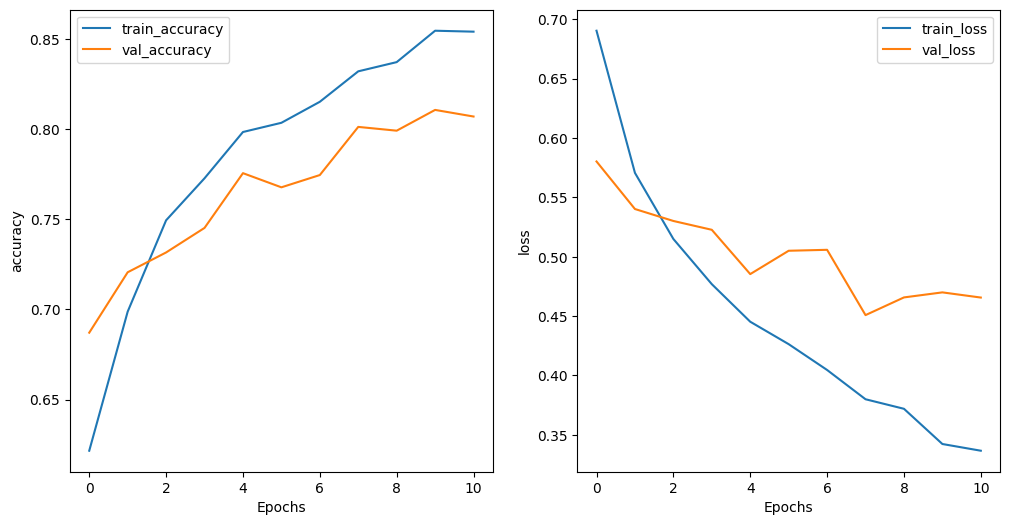

In [ ]:
plot_graphs(history=history,metric='accuracy', loss='loss')

In [ ]:
scores = model1.predict(xvalid_pad)
auc = metrics.roc_auc_score(y_test, scores)
print("Auc: %.2f%%" % (auc * 100))

75/75 [==============================] - 1s 6ms/step
Auc: 89.07%


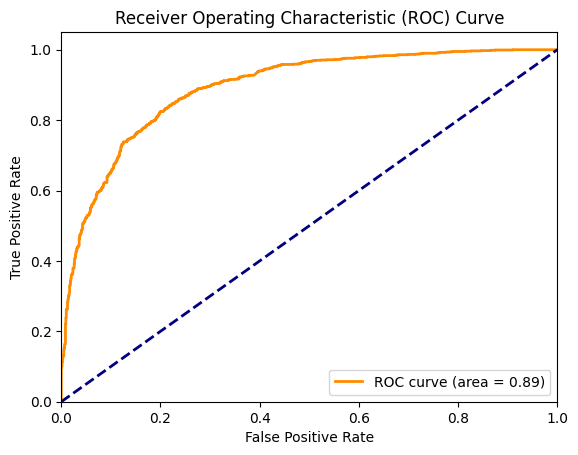

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Data Augmentation

In [ ]:
from textattack.augmentation import WordNetAugmenter, EmbeddingAugmenter
import random

def textattack_data_augment(data, target, texattack_augmenter):

  aug_data = []
  aug_label = []
  for text, label in zip(data, target):
    if random.randint(0,2) != 1:
      aug_data.append(text)
      aug_label.append(label)
      continue

    aug_list = texattack_augmenter.augment(text)
    aug_data.append(text)
    aug_label.append(label)
    aug_data.extend(aug_list)
    aug_label.extend([label]*len(aug_list))

  return aug_data, aug_label

In [ ]:
embed_aug = EmbeddingAugmenter(pct_words_to_swap=0.1, transformations_per_example=1)
aug_data, aug_lable = textattack_data_augment(kaggle_df["Text"], kaggle_df["oh_label"], embed_aug)

textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:11<00:00, 42.0MB/s]
textattack: Unzipping file /root/.cache/textattack/tmpvcv6w9q8.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Successfully saved word_embeddings/paragramcf to cache.


# Toxicity data

In [ ]:
toxicity_df = pd.read_csv('/content/drive/MyDrive/cyberbullying/toxicity_parsed_dataset.csv')
toxicity_df

,index,Text,ed_label_0,ed_label_1,oh_label
0,0,This: :One can make an analogy in mathematical...,0.9,0.1,0
1,1,` :Clarification for you (and Zundark's righ...,1.0,0.0,0
2,2,Elected or Electoral? JHK,1.0,0.0,0
3,3,`This is such a fun entry. Devotchka I once...,1.0,0.0,0
4,4,Please relate the ozone hole to increases in c...,0.8,0.2,0
...,...,...,...,...,...
159681,159681,` These sources don't exactly exude a sense ...,1.0,0.0,0
159682,159682,The Institute for Historical Review is a pee...,1.0,0.0,0
159683,159683,:The way you're trying to describe it in this...,1.0,0.0,0
159684,159684,== Warning == There is clearly a protection...,0.6,0.4,0


In [ ]:
toxicity_df.drop(columns=['index','ed_label_0','ed_label_1'], inplace=True)
toxicity_df.drop_duplicates(inplace=True)
toxicity_df

,Text,oh_label
0,This: :One can make an analogy in mathematical...,0
1,` :Clarification for you (and Zundark's righ...,0
2,Elected or Electoral? JHK,0
3,`This is such a fun entry. Devotchka I once...,0
4,Please relate the ozone hole to increases in c...,0
...,...,...
159681,` These sources don't exactly exude a sense ...,0
159682,The Institute for Historical Review is a pee...,0
159683,:The way you're trying to describe it in this...,0
159684,== Warning == There is clearly a protection...,0


In [ ]:
toxicity_df['Text'] = toxicity_df['Text'].apply(preprocessed_text)
toxicity_df

,Text,oh_label
0,one make analogy mathematical term envisioning...,0
1,clarification zundarks right checked wikipedia...,0
2,elected electoral jhk,0
3,fun entry devotchka coworker korea couldnt tel...,0
4,please relate ozone hole increase cancer provi...,0
...,...,...
159681,source dont exactly exude sense impartiality n...,0
159682,institute historical review peerreviewed journ...,0
159683,way youre trying describe article serious step...,0
159684,warning clearly protectionist regime going wit...,0


In [ ]:
toxicity_df.isnull().sum()

Text        0
oh_label    0
dtype: int64

In [ ]:
toxicity_df['oh_label'].value_counts()

0    144041
1     15348
Name: oh_label, dtype: int64

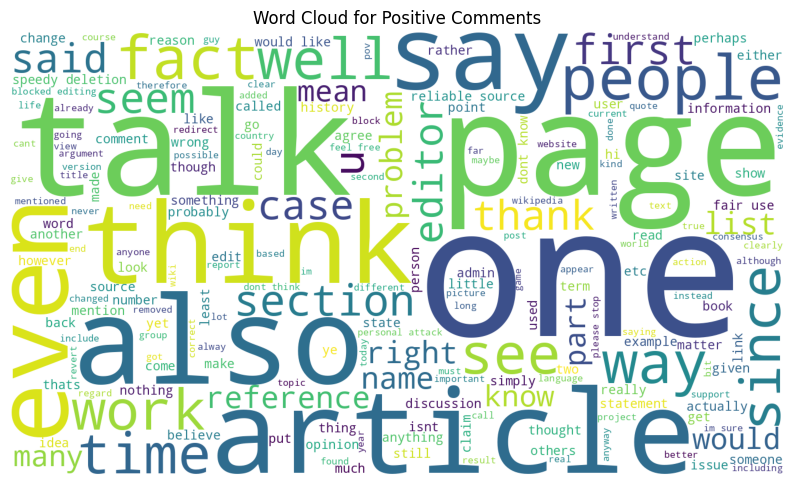

In [ ]:
%%time
stop_words = stopwords.words('english')
positive_comments = toxicity_df[toxicity_df['oh_label'] == 0]['Text']
pos = ' '.join(map(str, positive_comments))
pos_wordcloud = WordCloud(width=1400, height=800,
                          background_color='white',
                         stopwords=stop_words,
                          min_font_size=15).generate(pos)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Positive Comments')
plt.axis('off')
plt.show()

CPU times: user 34 s, sys: 1.74 s, total: 35.8 s
Wall time: 35.9 s


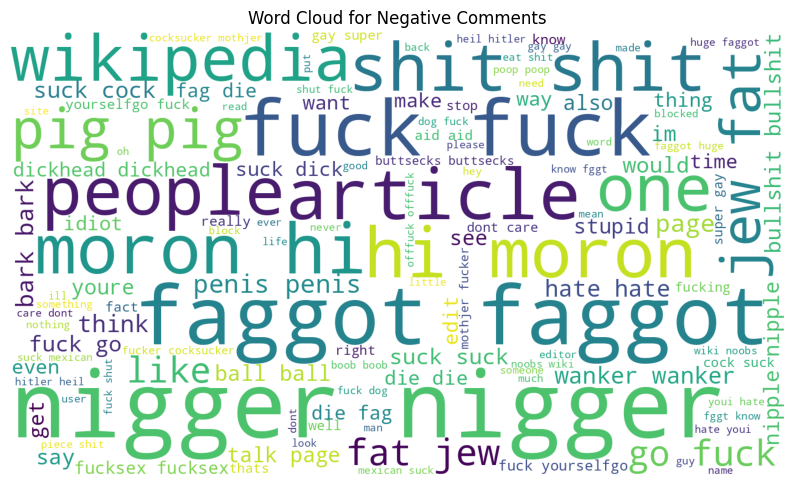

CPU times: user 3.89 s, sys: 257 ms, total: 4.15 s
Wall time: 4.03 s


In [ ]:
%%time
stop_words = stopwords.words('english')
positive_comments = toxicity_df[toxicity_df['oh_label'] == 1]['Text']
pos = ' '.join(map(str, positive_comments))
pos_wordcloud = WordCloud(width=1400, height=800,
                          background_color='white',
                         stopwords=stop_words,
                          min_font_size=15).generate(pos)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Negative Comments')
plt.axis('off')
plt.show()

In [ ]:
len_text = [len(tx) for tx in toxicity_df['Text'].to_list()]
print(f'Max Length : {np.max(len_text)}')
print(f'Min Length : {np.min(len_text)}')
print(f'Mean Length : {round(np.mean(len_text),2)}')
print(f'Std Length : {round(np.std(len_text),2)}')
print(f'Mew + 2sigma : {round(np.mean(len_text)+ 2 *np.std(len_text),2)}')

Max Length : 5000
Min Length : 0
Mean Length : 248.39
Std Length : 386.3
Mew + 2sigma : 1020.98


In [ ]:
# using the cleaned version of the dataset
ros = RandomOverSampler(random_state=42)
X = toxicity_df['Text'].values.reshape(-1, 1)
y = toxicity_df['oh_label'].values
X_resampled, y_resampled = ros.fit_resample(X, y)
X_resampled = X_resampled[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Create a Tokenizer object
token = Tokenizer()
max_len = 100

# Fit the Tokenizer on the training and testing data
token.fit_on_texts(list(X_train) + list(X_test))

# Generate sequences from the training and testing data
xtrain_seq = token.texts_to_sequences(X_train)
xvalid_seq = token.texts_to_sequences(X_test)

# Pad the sequences to the maximum length
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

# Get the word index
word_index = token.word_index

In [ ]:
vocab_length = len(token.word_index) + 1
vocab_length

213885

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 213884/213884 [00:00<00:00, 588042.38it/s]


In [ ]:
embedding_matrix.shape

(213885, 100)

In [ ]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_resampled)))

Original dataset shape Counter({0: 144041, 1: 15348})
Resampled dataset shape Counter({0: 144041, 1: 144041})


In [ ]:
%%time
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

    # A simple LSTM with glove embeddings and one dense layer
    model2 = Sequential()
    model2.add(Embedding(len(word_index) + 1,
                     100,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model2.add(LSTM(units=128, dropout=0.2))
    model2.add(Dense(1, activation='sigmoid'))
    model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          21388500  
                                                                 
 lstm_3 (LSTM)               (None, 128)               117248    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21505877 (82.04 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 21388500 (81.59 MB)
_________________________________________________________________
CPU times: user 522 ms, sys: 104 ms, total: 626 ms
Wall time: 698 ms


In [ ]:
history = model2.fit(xtrain_pad, y_train, epochs=10, batch_size=256*strategy.num_replicas_in_sync, validation_split=0.2)

Epoch 1/10
721/721 [==============================] - 13s 16ms/step - loss: 0.2971 - accuracy: 0.8717 - val_loss: 0.2327 - val_accuracy: 0.9005
Epoch 2/10
721/721 [==============================] - 11s 15ms/step - loss: 0.2303 - accuracy: 0.9034 - val_loss: 0.1983 - val_accuracy: 0.9168
Epoch 3/10
721/721 [==============================] - 11s 15ms/step - loss: 0.1990 - accuracy: 0.9170 - val_loss: 0.1711 - val_accuracy: 0.9291
Epoch 4/10
721/721 [==============================] - 11s 15ms/step - loss: 0.1751 - accuracy: 0.9288 - val_loss: 0.1488 - val_accuracy: 0.9407
Epoch 5/10
721/721 [==============================] - 11s 15ms/step - loss: 0.1581 - accuracy: 0.9367 - val_loss: 0.1285 - val_accuracy: 0.9505
Epoch 6/10
721/721 [==============================] - 11s 15ms/step - loss: 0.1366 - accuracy: 0.9465 - val_loss: 0.1294 - val_accuracy: 0.9504
Epoch 7/10
721/721 [==============================] - 11s 15ms/step - loss: 0.1233 - accuracy: 0.9534 - val_loss: 0.1223 - val_accuracy:

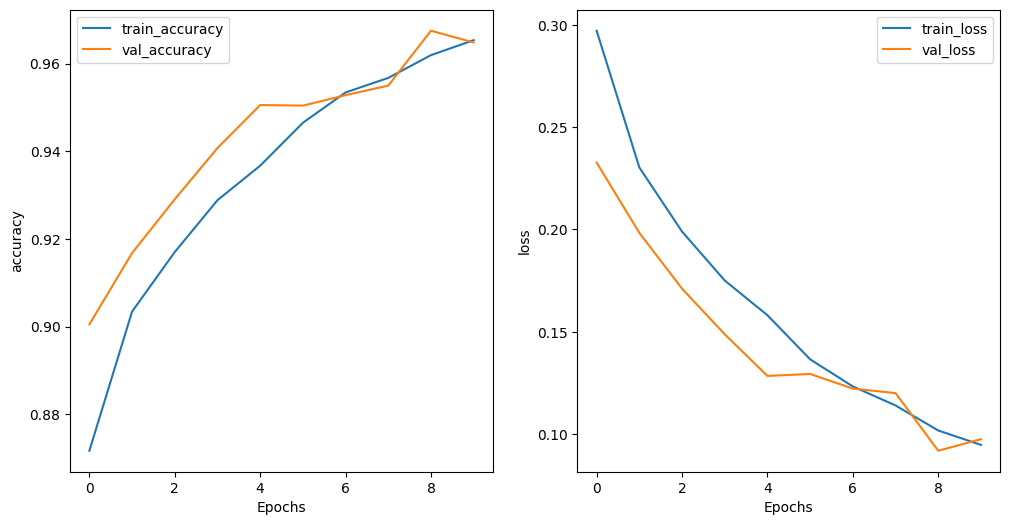

In [ ]:
plot_graphs(history=history,metric='accuracy', loss='loss')

In [ ]:
scores = model2.predict(xvalid_pad)
auc = metrics.roc_auc_score(y_test, scores)
print("Auc: %.2f%%" % (auc * 100))

1801/1801 [==============================] - 10s 5ms/step
Auc: 99.35%


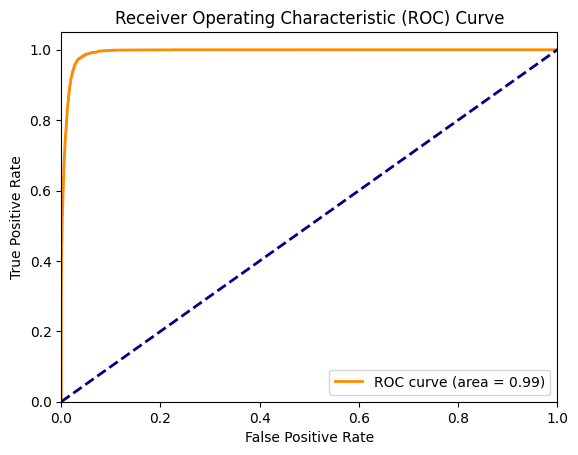

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()